In [6]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
import torch
from tqdm.autonotebook import tqdm, trange
import yaml

In [20]:
def load(path):
    with open(path) as fp:
        data = yaml.load(fp, Loader=yaml.CSafeLoader)

    pts = sorted(data["points"].keys())
    p2i = {k: i for i, k in enumerate(pts)}

    points = [[data["points"][i]["x"], data["points"][i]["y"]] for i in pts]

    distances = {(p2i[d["from"]], p2i[d["to"]]): d["d"] for d in data["distances"]}

    return points, distances

<IPython.core.display.Javascript object>

In [22]:
# load points and distances (no lock
points, distances = load("./terrasse.yml")

# number of iterations
n_iterations = 5000

<IPython.core.display.Javascript object>

In [48]:
import numpy as np

# create tensor of points
x = torch.tensor(points).requires_grad_(True)

# create the target tensor
target = torch.tensor(list(distances.values()), dtype=torch.float)


def loss_fn(x):
    d = torch.sqrt(
        torch.sum(torch.pow(x[list(distances.keys()), :].diff(axis=1), 2), axis=-1)
    ).squeeze()
    return d, torch.nn.functional.mse_loss(d, target)


optimizer = torch.optim.SGD([x], lr=0.01, momentum=0.9)

# optimization loop
tq = trange(n_iterations)
for i in tq:
    optimizer.zero_grad()
    d, loss = loss_fn(x)

    if i % 50 == 0:
        tq.set_postfix({"loss": loss.detach().numpy(), "distances": d.detach().numpy()})

    loss.backward()
    optimizer.step()

diffs = {}
for (i, j), d in distances.items():
    diffs[i, j] = abs(torch.nn.functional.pdist(x[[i, j], :]).item() - d)

ndiffs = np.array(list(diffs.values()))
print("===")
print(
    "min. = {}, max. = {}, sum. = {}".format(ndiffs.min(), ndiffs.max(), ndiffs.sum())
)

print(x)

  0%|          | 0/5000 [00:00<?, ?it/s]

===
min. = 0.0006171607971190429, max. = 0.05245639801025348, sum. = 0.3547315931320201
tensor([[-8.3360e-02, -5.3907e-02],
        [ 3.8064e-03,  1.8047e+00],
        [ 3.9424e+00,  1.8412e+00],
        [ 3.9264e+00,  3.7493e+00],
        [ 6.8665e+00,  3.8576e+00],
        [ 8.9221e+00,  3.7937e+00],
        [ 9.0355e+00,  5.9219e+00],
        [ 1.0619e+01,  5.8389e+00],
        [ 1.0448e+01,  9.6485e-02]], requires_grad=True)


<IPython.core.display.Javascript object>

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

diffs = {}
for (i, j), d in distances.items():
    diffs[i, j] = abs(torch.nn.functional.pdist(x[[i, j], :]).item() - d)

ndiffs = np.array(list(diffs.values()))
    
u = pd.DataFrame(diffs.values()).describe()


min. = 0    0.000617
Name: min, dtype: float64, max. = 0    0.052456
Name: max, dtype: float64, sum. = 0.3547315931320201


<IPython.core.display.Javascript object>

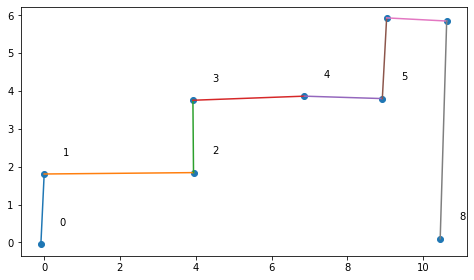

<IPython.core.display.Javascript object>

In [51]:
xv = x.detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_aspect("equal", "box")
ax.scatter(xv[:, 0], xv[:, 1])

for i, j in zip(range(len(points))[:-1], range(len(points))[1:]):
    ax.plot([xv[i, 0], xv[j, 0]], [xv[i, 1], xv[j, 1]])

for i in range(len(points)):
    ax.annotate(str(i), (xv[i, 0].item() + 0.5, xv[i, 1].item() + 0.5))